C:\Users\syf83691\AppData\Local\Temp\ipykernel_21696\1428450104.py:37: RuntimeWarning: divide by zero encountered in divide
  um = 1.0 / fxfinal #convert to wavelengths


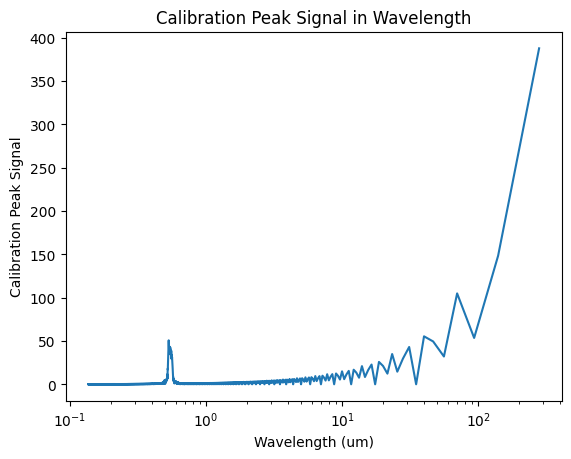

In [36]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt

def regularspacing(yhene, Ndet, NFFT): #calibration intensities, number of calibration intensities, next power of 2
    yhenesmooth = median_filter(yhene, 2) #reduces noise and dead pixels
    xhene = np.arange(1, Ndet + 1) #create indexes for yhene. Note that Matlab indexing starts on 1 insted of 0
    locs, _ = find_peaks(yhenesmooth) #locations of our fringes.
    locs += 1 #+1 because Matlab uses 1 based indexing
    N = len(locs) #number of fringes

    xpos = np.linspace(locs[0], locs[-1], N) #liniarly spaced version of the fringe locations
    p = np.polynomial.polynomial.Polynomial.fit(xpos, locs, 3) #nppoly does some crazy eigenvector stuff. Use p.convert().coef to get the acual coeffients. Gives a different result from matlab.
    ypos_fit = p(xhene) #liniarise the indexes
    yi = np.interp(xhene, ypos_fit, yhene) #map the indexes to the interferogram using liniar interpolation where nessisary.
    yinorm = (yi / np.max(yi)) * -1 + 1 #normalise and invert new liniar interferogram. (why invert???)

    p = np.array([list(p)]*Ndet)
    p[:,3] -= xhene
    rnreal = [np.polynomial.polynomial.polyroots(polynomial)[2].real for polynomial in p] #find the x intercept of the linierising polynomial. rnreal = 0 for no chirping. Somehow the last solution is never complex?
    return yi, xhene, yinorm, rnreal

def newpeakfind(yhene, line_centre, Ndet):
    locs, _ = find_peaks(yhene) #locations of our fringes
    N = len(locs) #number of fringes
    ypos = line_centre * np.arange(1, N + 1) #theortical temporal positions of the fringes
    newp = np.polyfit(locs, ypos, 2) #create a polynomial function that maps the calibration to the theortical fringes. Should be something like, newp = [0,2sin(theta),2sin(theta)*phi] where phi is the phase difference.
    NFFT = 2 ** int(np.ceil(np.log2(Ndet))) #next power of 2. Not sure what this achives.
    xcal = np.polyval(newp, np.arange(1, NFFT + 1)) #create and map the indexes of the calibration interferogram to the theortical interferogram.
    dx = np.diff(xcal) #find the intervals between the indexes. Remember that xcal follows [2sin(theta)*gamma +2sin(theta)*phi] so dx follows [2sin(theta)]
    dx = np.append(dx, dx[-1]) #make len(dx) == len(xcal)
    dx = dx[Ndet//2] #take the middle value. the middle value should have the best S:N ratio. dx = 2sin(theta)
    Fs = 1.0 / dx #Fs = 1/2sin(theta)
    fxfinal = Fs / 2 * np.linspace(0, 1, int(NFFT / 2) + 1) #find wavenumbers upto the nyquist frequency
    um = 1.0 / fxfinal #convert to wavelengths

    return fxfinal, um

# Import calibration data
calibration_data = np.loadtxt('data\\henefordoubletsignal170216.txt')
xhene_calib = calibration_data[:, 0]
yhene_calib = calibration_data[:, 1]

pixelsize = 2.2
theta = 1.8
line_centre = 0.546 #um

xaxiscalibpixel = 0
sin_theta_incident = np.sin(np.radians(theta))

Ndet = len(yhene_calib) #number of calibration data points
NFFT = 2 ** int(np.ceil(np.log2(Ndet))) #next power of 2
yi, xhene, yinorm, rnreal = regularspacing(yhene_calib, Ndet, NFFT)

if xaxiscalibpixel == 0:
    fx, um = newpeakfind(yhene_calib, line_centre, Ndet) #because we have a known calibration wavelength, we can calculate theta.
else:
    pixelsize = 2.2 #if we have a known theta, we can use that insted
    Fs = 1 / pixelsize
    fx = Fs / 2 * np.linspace(0, 1, int(NFFT / 2) + 1)
    um1 = fx / (2 * sin_theta_incident)
    um = 1 / um1

Yc = np.fft.fft(yi, NFFT) / Ndet #optimised and normalised fft. 
B1 = 2 * np.abs(Yc[:NFFT // 2 + 1]) #convert fourier coeffients to amplitudes. wavenumber = 0 case is deleted.
B2 = np.vstack((um, B1)).T #why not hstack or columnstack?

plt.plot(B2[:, 0], B2[:, 1])
plt.xlabel('Wavelength (um)')
plt.ylabel('Calibration Peak Signal')
plt.title('Calibration Peak Signal in Wavelength')
plt.xscale("log")
plt.show()


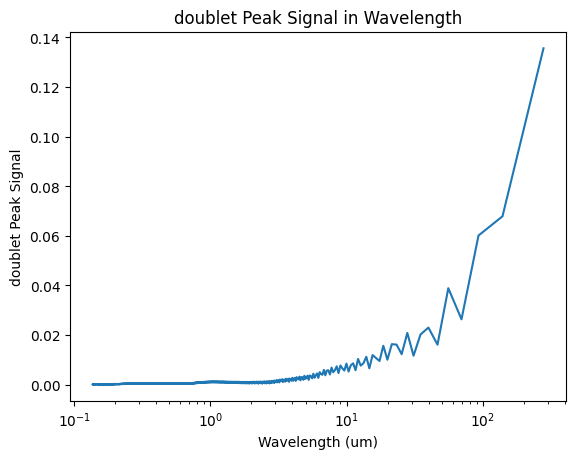

In [64]:
# Import interferogram data
interferogram_data = np.loadtxt('data\\doubletsignal170216.txt') #interferogram of interest. can be broadband
xhene_interfero = interferogram_data[:, 0]
yhene_interfero = interferogram_data[:, 1]
yhene_interfero -= 0.5 #removing wavenumber = 0 component?
# Elin also takes the real component of yhene_interfero but yhene_interfero shouldn't be complex to begin with?
yhene_interfero = np.interp(rnreal, xhene, yhene_interfero)

Yc = np.fft.fft(yhene_interfero, NFFT) / Ndet #optimised and normalised fft. 
B1 = 2 * np.abs(Yc[:NFFT // 2 + 1]) #convert fourier coeffients to amplitudes. wavenumber = 0 case is deleted.
B2 = np.vstack((um, B1)).T #why not hstack or columnstack?

plt.plot(B2[:, 0], B2[:, 1])
plt.xlabel('Wavelength (um)')
plt.ylabel('doublet Peak Signal')
plt.title('doublet Peak Signal in Wavelength')
plt.xscale("log")
plt.show()